In [3]:
import pandas as pd
import pandas_gbq
import numpy as np
import re
import matplotlib.pyplot as plt
from statistics import mean
import json
from google.cloud import bigquery
import requests
import statistics
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')
import os
import importlib.resources
from google.oauth2 import service_account
from numpy import mean
from numpy import std
from numpy.random import seed
from sklearn import datasets
from scipy.cluster.hierarchy import *
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from pathlib import Path
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder
import math 

In [4]:
credentials = service_account.Credentials.from_service_account_file(r'C:\Users\aleks\bigquery_key.json')
pandas_gbq.context.credentials = credentials
pandas_gbq.context.progect = "astute-asset-303615" 

# ROI по каждому источнику

In [5]:
ROI_3_source_medium="""WITH
    costs as (
      SELECT EXTRACT(month FROM date) as month,
      source,
      sum(cost) as cost
      FROM
      (
        SELECT date, 'admitad' AS source, cost
        FROM `Project_3.admitad_data`
        UNION ALL
        SELECT date, 'google'AS source, cost
        FROM `Project_3.g_ads_data`
        UNION ALL
        SELECT date, 'yandex' AS source, cost
        FROM `Project_3.ya_direct_data`
      )
      GROUP BY 1,2
      ORDER BY 1
    ),
    ga as (
            SELECT EXTRACT (month FROM ga.date) AS month,
            ga.source,
            ga.medium,
            SUM(ga.revenue) AS revenue
            FROM `Project_3.ga_data` as ga
            WHERE (ga.source = 'admitad' AND ga.medium= 'cpa') OR (ga.source in ('google', 'yandex') AND ga.medium='cpc')
            GROUP BY 1,2,3
            ORDER BY 1
    )

    SELECT costs.month,
    ga.source,
    ga.medium,
    ga.revenue,
    costs.cost,
    ROUND((ga.revenue-costs.cost)/costs.cost*100, 2) AS ROI
    FROM ga
    LEFT JOIN costs using(month,source)
    ORDER BY 1,2"""

data_ROI_3_source_medium= pandas_gbq.read_gbq(ROI_3_source_medium, project_id='astute-asset-303615')
data_ROI_3_source_medium.head(10)

Downloading: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 99.89rows/s]


,month,source,medium,revenue,cost,ROI
0,1,admitad,cpa,268239.0,30521.87,778.84
1,1,google,cpc,20707651.0,2240041.50,824.43
2,1,yandex,cpc,33114288.0,4131803.30,701.45
3,2,admitad,cpa,8591937.0,965878.12,789.55
4,2,google,cpc,23530434.0,2481776.60,848.13
5,2,yandex,cpc,35484582.0,4424369.60,702.03
6,3,admitad,cpa,7633603.0,884960.83,762.59
7,3,google,cpc,22934453.0,2600731.40,781.85
8,3,yandex,cpc,32405444.0,4129026.80,684.82
9,4,admitad,cpa,6332475.0,719611.07,779.99


# CTR, CPA, CR

In [6]:
CTR_CPA_CR ="""WITH
   costs as ( 
     SELECT EXTRACT(month from date) as month,
       source,
       SUM(cost) AS cost,
       SUM(clicks) as clicks,
       SUM(impressions) AS impressions
       FROM
   (
        SELECT date, 'admitad' AS source, cost, NULL as clicks, null as impressions
        FROM `Project_3.admitad_data`
        UNION ALL
        SELECT date, 'google'AS source, cost, clicks, impressions 
        FROM `Project_3.g_ads_data`
        UNION ALL
        SELECT date, 'yandex' AS source, cost, clicks, impressions
        FROM `Project_3.ya_direct_data`
      )
      GROUP BY 1,2
      ORDER BY 1
   ),
   ga as (
     SELECT EXTRACT(month from date) as month,
     ga.source,
     ga.medium,
     sum(ga.transactions) AS transactions,
     sum(ga.visits) AS visits
     FROM `Project_3.ga_data` as ga
     WHERE (ga.source = 'admitad' AND ga.medium= 'cpa') OR (ga.source in ('google', 'yandex') AND ga.medium='cpc')
     GROUP BY 1,2,3
     ORDER BY 1
   )
SELECT costs.month,
       ga.source,
       ga.medium,
       costs.cost,
       ga.transactions,
       ga.visits,
       CASE WHEN costs.impressions IS NULL THEN 0 else ROUND(costs.clicks/costs.impressions*100, 2) end AS CTR,
       ROUND (costs.cost/ga.transactions, 2) as CPA,
       ROUND (ga.transactions/ga.visits*100, 2) as CR
  FROM ga
  LEFT JOIN costs using(month, source)
  ORDER BY 1,2"""

data_CTR_CPA_CR= pandas_gbq.read_gbq(CTR_CPA_CR, project_id='astute-asset-303615')
data_CTR_CPA_CR.head(10)

Downloading: 100%|██████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 100.52rows/s]


,month,source,medium,cost,transactions,visits,CTR,CPA,CR
0,1,admitad,cpa,30521.87,236,1374,0.00,129.33,17.18
1,1,google,cpc,2240041.50,15651,105075,5.77,143.12,14.90
2,1,yandex,cpc,4131803.30,24311,152356,4.73,169.96,15.96
3,2,admitad,cpa,965878.12,6691,54529,0.00,144.35,12.27
4,2,google,cpc,2481776.60,17034,115888,5.11,145.70,14.70
5,2,yandex,cpc,4424369.60,25344,154999,4.46,174.57,16.35
6,3,admitad,cpa,884960.83,6216,50441,0.00,142.37,12.32
7,3,google,cpc,2600731.40,18065,117168,5.52,143.97,15.42
8,3,yandex,cpc,4129026.80,24136,142502,5.03,171.07,16.94
9,4,admitad,cpa,719611.07,5840,55388,0.00,123.22,10.54


# CR по городам

In [7]:
CR_city="""SELECT EXTRACT(MONTH FROM date) AS the_month,
       city,
       sum(transactions) as transactions,
       sum(visits) as visits,
       round(sum(transactions)/sum(visits)*100) as CR
 FROM `astute-asset-303615.Project_3.ga_data`
 group by 1,2
 order by 1"""

data_CR_city= pandas_gbq.read_gbq(CR_city, project_id='astute-asset-303615')
data_CR_city.head(10)

Downloading: 100%|███████████████████████████████████████████████████████████████| 653/653 [00:00<00:00, 1410.11rows/s]


,the_month,city,transactions,visits,CR
0,1,Уфа,660,4289,15.0
1,1,Не определено,11584,113671,10.0
2,1,Москва,52102,314286,17.0
3,1,Зеленоград,716,2671,27.0
4,1,Красноярск,1522,11007,14.0
5,1,Иркутск,5070,23744,21.0
6,1,Сургут,357,3396,11.0
7,1,Краснодар,1324,9060,15.0
8,1,Балашиха,501,2870,17.0
9,1,Кемерово,2327,11520,20.0


# Воронка продаж

In [8]:
# Воронка продаж по использованию фильтра


sales_funnel_with_filter_used ="""WITH
ga as
(
  SELECT filter_used_on_off,
       COUNT (DISTINCT clientId) AS count_Users,
       COUNT (CASE WHEN visits > 0 THEN 'visits' else NULL END) AS visits,
       COUNT (CASE WHEN productClick > 0 THEN 'productClick' else NULL END) AS productClick,
       COUNT (CASE WHEN addToCart > 0 THEN 'addToCart' else NULL END) AS addToCart,
       COUNT (CASE WHEN checkout > 0 THEN 'checkout' else NULL END) AS checkout,
       COUNT (CASE WHEN transactions > 0 THEN 'transactions' else NULL END) AS transactions
       FROM
            (
              SELECT*,IF(filter_used=0, 'off', 'on') as filter_used_on_off
              FROM `Project_3.ga_data`
            )
            GROUP BY 1
)
SELECT
filter_used_on_off,
count_Users,
visits,
productClick,
addToCart,
checkout,
transactions,
ROUND(SUM(productClick)/SUM(visits)*100) AS CR_ProductClick,
ROUND(SUM(addToCart)/SUM(visits)*100) AS CR_addToCart,
ROUND(SUM(checkout)/SUM(visits)*100) AS CR_checkout,
ROUND(SUM(transactions)/SUM(visits)*100) AS CR_transactions
FROM ga
GROUP BY 1,2,3,4,5,6,7"""

data_sales_funnel_with_filter_used = pandas_gbq.read_gbq(sales_funnel_with_filter_used, project_id='astute-asset-303615')
data_sales_funnel_with_filter_used.head(10)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.56rows/s]


,filter_used_on_off,count_Users,visits,productClick,addToCart,checkout,transactions,CR_ProductClick,CR_addToCart,CR_checkout,CR_transactions
0,off,5032589,7881117,2127428,2120881,2068537,1335215,27.0,27.0,26.0,17.0
1,on,126001,150713,112248,112089,98542,62387,74.0,74.0,65.0,41.0


In [9]:
# Воронка продаж по возможности доставки


sales_funnel_with_delivery_available="""WITH
ga as
(
  SELECT delivery_yes_no,
       COUNT (DISTINCT clientId) AS count_Users,
       COUNT (CASE WHEN visits > 0 THEN 'visits' else NULL END) AS visits,
       COUNT (CASE WHEN productClick > 0 THEN 'productClick' else NULL END) AS productClick,
       COUNT (CASE WHEN addToCart > 0 THEN 'addToCart' else NULL END) AS addToCart,
       COUNT (CASE WHEN checkout > 0 THEN 'checkout' else NULL END) AS checkout,
       COUNT (CASE WHEN transactions > 0 THEN 'transactions' else NULL END) AS transactions
       FROM
            (
              SELECT*,IF(delivery_available='Доставка есть', 'yes', 'no') as delivery_yes_no
              FROM `Project_3.ga_data`
            )
            GROUP BY 1
)
SELECT
delivery_yes_no,
count_Users,
visits,
productClick,
addToCart,
checkout,
transactions,
ROUND(SUM(productClick)/SUM(visits)*100) AS CR_ProductClick,
ROUND(SUM(addToCart)/SUM(visits)*100) AS CR_addToCart,
ROUND(SUM(checkout)/SUM(visits)*100) AS CR_checkout,
ROUND(SUM(transactions)/SUM(visits)*100) AS CR_transactions
FROM ga
GROUP BY 1,2,3,4,5,6,7"""

data_sales_funnel_with_delivery_available = pandas_gbq.read_gbq(sales_funnel_with_delivery_available, project_id='astute-asset-303615')
data_sales_funnel_with_delivery_available.head(10)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.18rows/s]


,delivery_yes_no,count_Users,visits,productClick,addToCart,checkout,transactions,CR_ProductClick,CR_addToCart,CR_checkout,CR_transactions
0,no,4899139,7446477,1697075,1691468,1589533,959281,23.0,23.0,21.0,13.0
1,yes,494600,585353,542601,541502,577546,438321,93.0,93.0,99.0,75.0


In [10]:
# Воронка продаж по типу устройства

sales_funnel_with_device_type = """WITH
ga as
(
  SELECT device_type,
       COUNT (DISTINCT clientId) AS count_Users,
       COUNT (CASE WHEN visits > 0 THEN 'visits' else NULL END) AS visits,
       COUNT (CASE WHEN productClick > 0 THEN 'productClick' else NULL END) AS productClick,
       COUNT (CASE WHEN addToCart > 0 THEN 'addToCart' else NULL END) AS addToCart,
       COUNT (CASE WHEN checkout > 0 THEN 'checkout' else NULL END) AS checkout,
       COUNT (CASE WHEN transactions > 0 THEN 'transactions' else NULL END) AS transactions
       FROM `Project_3.ga_data`
       GROUP BY 1
          )
SELECT
device_type,
count_Users,
visits,
productClick,
addToCart,
checkout,
transactions,
ROUND(SUM(productClick)/SUM(visits)*100) AS CR_ProductClick,
ROUND(SUM(addToCart)/SUM(visits)*100) AS CR_addToCart,
ROUND(SUM(checkout)/SUM(visits)*100) AS CR_checkout,
ROUND(SUM(transactions)/SUM(visits)*100) AS CR_transactions
FROM ga
GROUP BY 1,2,3,4,5,6,7"""

data_sales_funnel_with_device_type= pandas_gbq.read_gbq(sales_funnel_with_device_type, project_id='astute-asset-303615')
data_sales_funnel_with_device_type.head(10)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.69rows/s]


,device_type,count_Users,visits,productClick,addToCart,checkout,transactions,CR_ProductClick,CR_addToCart,CR_checkout,CR_transactions
0,Мобайл,3301226,4907197,1320270,1319673,1345581,680818,27.0,27.0,27.0,14.0
1,Десктоп,1696793,2634539,919401,913292,821492,523183,35.0,35.0,31.0,20.0
2,Не определено,426509,490094,5,5,6,193601,0.0,0.0,0.0,40.0


# 2 этап курсовой

In [11]:
# ARPU и ARPPU

ARPU_ARPPU = """SELECT date,
       COUNT(distinct clientID) as client_id,
       SUM(paying_users) as paying_Users,
       ROUND(SUM(revenue)/COUNT(distinct clientID), 2) as ARPU,
       ROUND(SUM(revenue)/SUM(paying_users), 2) as ARPPU
       FROM (
         SELECT date,
                revenue,
                clientId,
                CASE WHEN transactions >0 THEN 1 ELSE 0 END AS paying_Users
                FROM `Project_3.ga_data`
                GROUP BY 1,2,3,4
       )

GROUP BY 1
ORDER BY 1"""

data_ARPU_ARPPU= pandas_gbq.read_gbq(ARPU_ARPPU, project_id='astute-asset-303615')
data_ARPU_ARPPU.head(10)

Downloading: 100%|████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 869.10rows/s]


,date,client_id,paying_Users,ARPU,ARPPU
0,2020-01-01,16973,3050,207.53,1154.90
1,2020-01-02,21562,4145,225.54,1173.24
2,2020-01-03,21909,4211,226.92,1180.62
3,2020-01-04,22853,4481,233.30,1189.83
4,2020-01-05,22242,4432,238.22,1195.50
5,2020-01-06,21467,4205,233.57,1192.40
6,2020-01-07,21296,4310,242.28,1197.13
7,2020-01-08,18582,3565,232.94,1214.18
8,2020-01-09,16518,2828,290.54,1697.00
9,2020-01-10,17945,3516,268.82,1372.03


In [12]:
data_ARPU_ARPPU.describe()

,client_id,paying_Users,ARPU,ARPPU
count,366.000000,366.000000,366.000000,366.000000
mean,19004.811475,3815.401639,245.316257,1247.258743
std,4297.920536,1218.896087,31.300914,123.091177
min,12223.000000,1872.000000,157.300000,1058.600000
25%,15637.250000,2814.500000,226.962500,1173.285000
50%,18314.500000,3648.500000,243.040000,1229.680000
75%,21407.750000,4473.250000,263.770000,1280.060000
max,47445.000000,9508.000000,377.240000,1879.730000


# Средний доход с пользователя (ARPU) - Меры центральной тенденции: среднее значение, медиана, мода

In [13]:
data_ARPU_ARPPU['ARPU'].describe()

count    366.000000
mean     245.316257
std       31.300914
min      157.300000
25%      226.962500
50%      243.040000
75%      263.770000
max      377.240000
Name: ARPU, dtype: float64

Среднее значение: 245.32


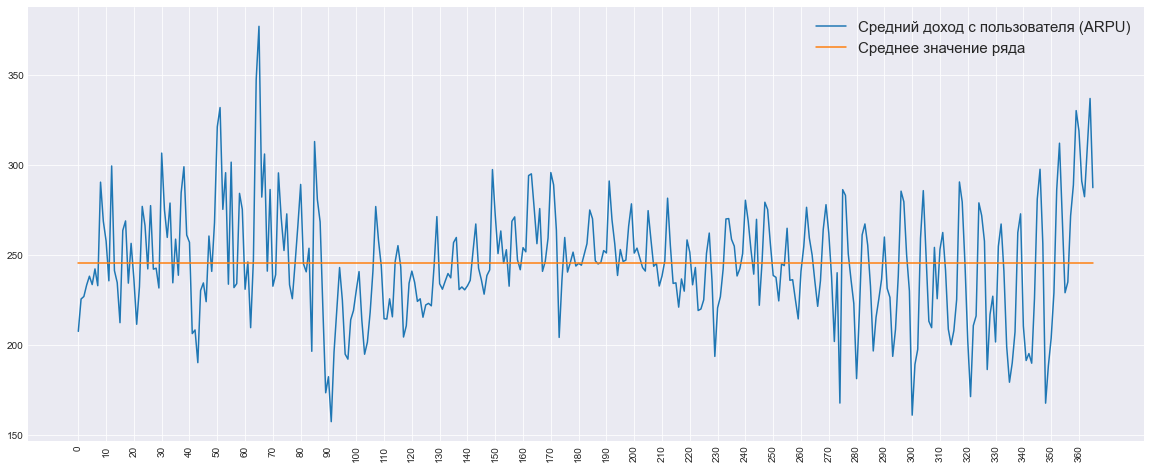

In [14]:
# Среднее значение
data_ARPU_ARPPU['Mean'] = data_ARPU_ARPPU['ARPU'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(data_ARPU_ARPPU['ARPU'], label = 'Средний доход с пользователя (ARPU)')
plt.plot(data_ARPU_ARPPU['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size':15})
plt.xticks(range(0, len(data_ARPU_ARPPU), 10), data_ARPU_ARPPU.index[range(0, len(data_ARPU_ARPPU),10)], rotation = '90')

# Среднее значение
print("Среднее значение:", round(data_ARPU_ARPPU['ARPU'].mean(),2))

In [15]:
print('Медиана ARPU:', round(data_ARPU_ARPPU['ARPU'].median(),2))
print("Среднее значение ARPU:", round(data_ARPU_ARPPU['ARPU'].mean(),2))
print('Мода ARPU:', round(data_ARPU_ARPPU['ARPU'].mode(),2))

Медиана ARPU: 243.04
Среднее значение ARPU: 245.32
Мода ARPU: 0    209.59
1    219.13
2    238.63
3    242.28
4    256.31
5    259.76
dtype: float64


# Вывод
   1.  В среднем доход на пользователя составляет 245,32 (Среднее значение ARPU)
   2.  Значение, находящиеся в середине выборки составляет 243,04 (Медиана ARPU)
   3.  В нашей выборке имеется семь самых встречающихся значений (Мода ARPU):
   4.  Среднее значение ARPU(245.32) примерно равно медиане ARPU(243.04), соответственно гипотеза о нормальности данных не отвергается 

# Квантили ARPU

max: 377
75%: 264
50%: 243
25%: 227
min: 157


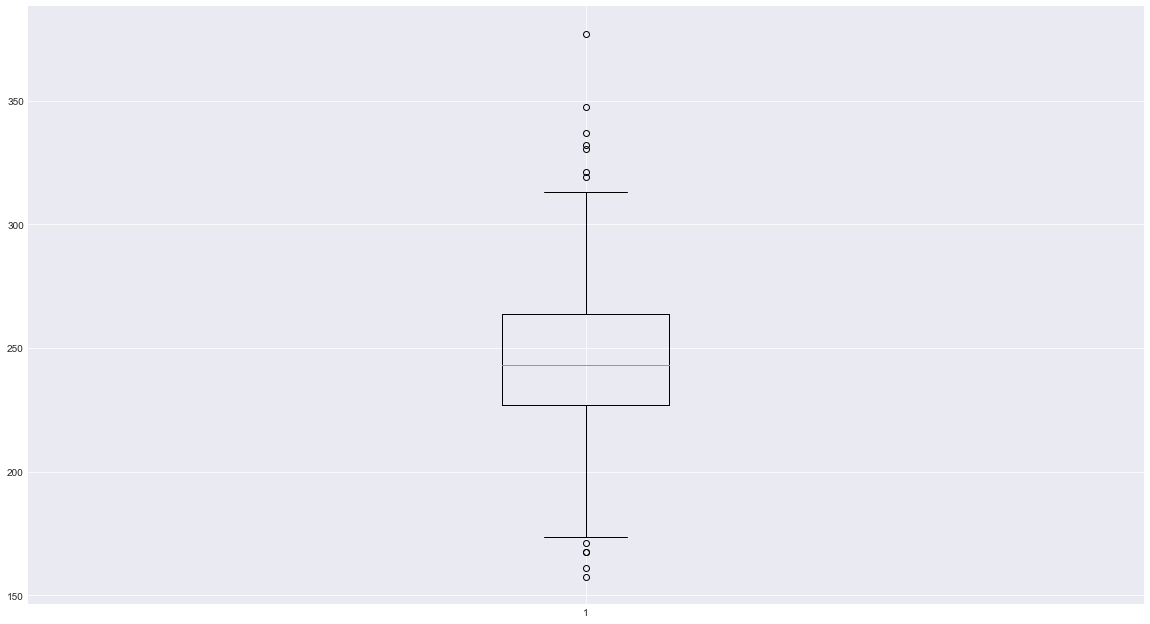

In [16]:
print('max:', round(data_ARPU_ARPPU['ARPU'].quantile(q=1.0)))
print('75%:', round(data_ARPU_ARPPU['ARPU'].quantile(q=0.75)))
print('50%:', round(data_ARPU_ARPPU['ARPU'].quantile(q=0.5)))
print('25%:', round(data_ARPU_ARPPU['ARPU'].quantile(q=0.25)))
print('min:', round(data_ARPU_ARPPU['ARPU'].quantile(q=0.0)))


np.random.seed(10)
data = np.random.normal(50, 10, 100)
 
fig = plt.figure(figsize =(20, 11))
 

plt.boxplot(data_ARPU_ARPPU['ARPU'])
 

plt.show()

# Вывод:
   1. До 25% данных имеют значение 227, что выше минимального показателя на 70. При увеличении вероятности с 25% по 50% и с 50% по 75% не происходит стремительного роста, в первом случае он составляет 16, а во втором 21. Самая большая разница имеется между последними квантилями и она равна 113 платежам. 
   2. На диаграмме видно, что 50% данных имеют примерно одинаковые значения и большого разброса не наблюдается, однако есть выбросы, что свидетельствует о наличии нетипичных наблюдений.

# Средний доход с пользователя (ARPPU) - Меры центральной тенденции: среднее значение, медиана, мода

In [17]:
data_ARPU_ARPPU['ARPPU'].describe()

count     366.000000
mean     1247.258743
std       123.091177
min      1058.600000
25%      1173.285000
50%      1229.680000
75%      1280.060000
max      1879.730000
Name: ARPPU, dtype: float64

Среднее значение: 1247.26


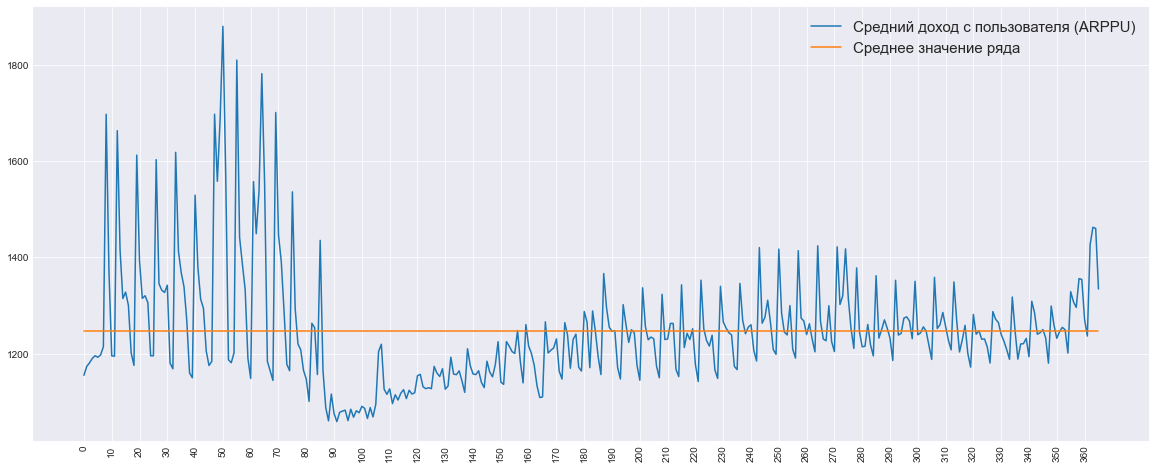

In [18]:
# Среднее значение
data_ARPU_ARPPU['Mean'] = data_ARPU_ARPPU['ARPPU'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(data_ARPU_ARPPU['ARPPU'], label = 'Средний доход с пользователя (ARPPU)')
plt.plot(data_ARPU_ARPPU['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size':15})
plt.xticks(range(0, len(data_ARPU_ARPPU), 10), data_ARPU_ARPPU.index[range(0, len(data_ARPU_ARPPU),10)], rotation = '90')

# Среднее значение
print("Среднее значение:", round(data_ARPU_ARPPU['ARPPU'].mean(),2))

In [19]:
print("Среднее значение:", round(data_ARPU_ARPPU['ARPPU'].mean(),2))
print('Медиана ARPPU:', round(data_ARPU_ARPPU['ARPPU'].median(),2))
print('Мода ARPPU:', round(data_ARPU_ARPPU['ARPPU'].mode(),2))

Среднее значение: 1247.26
Медиана ARPPU: 1229.68
Мода ARPPU: 0    1201.11
1    1243.05
dtype: float64


# Вывод
   1.  В среднем выручка на одного платящего пользователя составляет 1247,26 (Среднее значение ARPPU)
   2.  Значение, находящиеся в середине выборки составляет 1229,68 (Медиана ARPPU)
   3.  В нашей выборке имеются три самых встречающихся значения (Мода ARPPU):
   4.  Среднее значение ARPPU(1247,26) примерно равно медиане ARPPU(1229,68), соответственно гипотеза о нормальности данных не отвергается

# Квантили ARPPU

max: 1880
75%: 1280
50%: 1230
25%: 1173
min: 1059


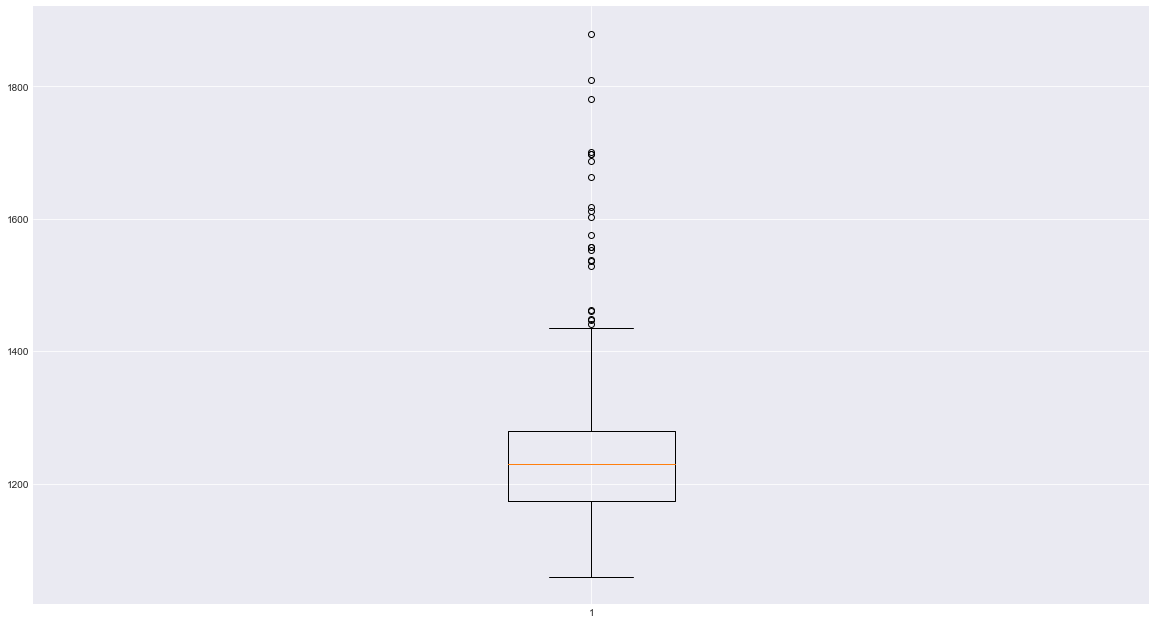

In [20]:
print('max:', round(data_ARPU_ARPPU['ARPPU'].quantile(q=1.0)))
print('75%:', round(data_ARPU_ARPPU['ARPPU'].quantile(q=0.75)))
print('50%:', round(data_ARPU_ARPPU['ARPPU'].quantile(q=0.5)))
print('25%:', round(data_ARPU_ARPPU['ARPPU'].quantile(q=0.25)))
print('min:', round(data_ARPU_ARPPU['ARPPU'].quantile(q=0.0)))


np.random.seed(10)
data = np.random.normal(50, 10, 100)
 
fig = plt.figure(figsize =(20, 11))
 

plt.boxplot(data_ARPU_ARPPU['ARPPU'])
 

plt.show()

# Вывод:
   1. До 25% данных имеют значение 1173, что выше минимального показателя на 114. При увеличении вероятности с 25% по 50% и с 50% по 75% не происходит стремительного роста, в первом случае он составляет 57, а во втором 50. Самая большая разница имеется между последними квантилями и она равна 600 платежам.
   2. На диаграмме видно, что 50% данных имеют примерно одинаковые значения и большого разброса не наблюдается, однако есть выбросы, что свидетельствует о наличии нетипичных наблюдений.

# Сравнение результатов по показателям ARPU и ARPPU

In [21]:
print("Среднее значение ARPU:", round(data_ARPU_ARPPU['ARPU'].mean(),2))
print("Среднее значение ARPPU:", round(data_ARPU_ARPPU['ARPPU'].mean(),2))

Среднее значение ARPU: 245.32
Среднее значение ARPPU: 1247.26


In [22]:
print("Дисперсия ARPU:", round(data_ARPU_ARPPU['ARPU'].var(),2))
print("Дисперсия ARPPU:", round(data_ARPU_ARPPU['ARPPU'].var(),2))

Дисперсия ARPU: 979.75
Дисперсия ARPPU: 15151.44


In [23]:
print("Стандартное отклонение ARPU:", round(data_ARPU_ARPPU['ARPU'].std(),2))
print("Стандартное отклонение ARPPU:", round(data_ARPU_ARPPU['ARPPU'].std(),2))

Стандартное отклонение ARPU: 31.3
Стандартное отклонение ARPPU: 123.09


# Выводы
   1. Дисперсия существенно выше по метрике ARPPU.
   2. Стандартное отклонение выше у ARPPU.
   3. Из результатов расчётов дисперсии и стандартного отклонения следует вывод о наличии большого различия между средним показателем и наблюдаемыми значениями.

In [24]:
data_ARPU_ARPPU.index = data_ARPU_ARPPU['date']
data_ARPU_ARPPU = data_ARPU_ARPPU.drop(['date'], axis = 1)
data_ARPU_ARPPU

,client_id,paying_Users,ARPU,ARPPU,Mean
date,,,,,
2020-01-01,16973,3050,207.53,1154.90,1247.258743
2020-01-02,21562,4145,225.54,1173.24,1247.258743
2020-01-03,21909,4211,226.92,1180.62,1247.258743
2020-01-04,22853,4481,233.30,1189.83,1247.258743
2020-01-05,22242,4432,238.22,1195.50,1247.258743
...,...,...,...,...,...
2020-12-27,22859,5382,291.10,1236.39,1247.258743
2020-12-28,21023,4163,282.45,1426.37,1247.258743
2020-12-29,22795,4832,309.99,1462.36,1247.258743


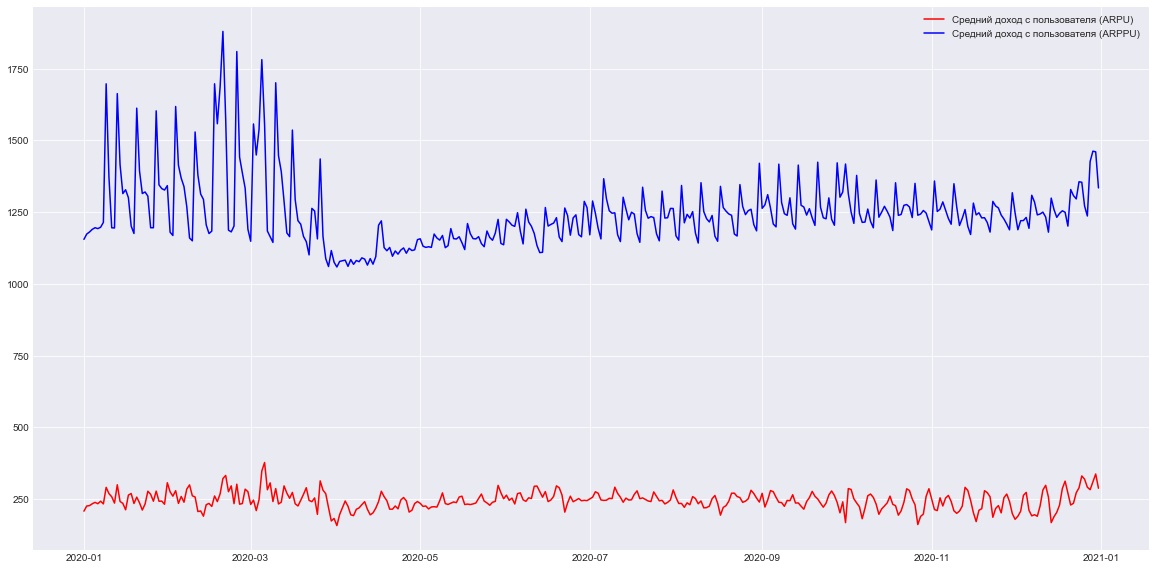

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(data_ARPU_ARPPU['ARPU'], color = 'r', label = 'Средний доход с пользователя (ARPU)')
plt.plot(data_ARPU_ARPPU['ARPPU'], color = 'b', label = 'Средний доход с пользователя (ARPPU)')
plt.legend()
plt.show()

# Вывод
1. Меры разброса данных у ARPPU выше чем у ARPU, в связи с тем, что первая метрика учитывает средний чек и количество проданных товаров, соответственно, сумма платежей может кардинально отличаться. Вторая метрика характеризуется общей активностью по совершению денежных транзакций, например при уменьшении затрат на совершение заказов, пользователь полностью не отказывается от услуг доставки товаров.
2. Период когда ARPU и ARPPU показывают максимамльные значения приходится на январь-март. Гипотеза: данная ситуация обусловлена увеличением количества заказов в праздничные дни.
3. Самое малое количество платежей приходится на апрель месяц. Гипотеза: такое положение дел связано с введением режима самоизоляции в период пандемии коронавируса и оно заключается в следующих причинах:
    - работники были переведены на удалённый режим работы, соответственно меньше стало осуществляться заказов в офис и люди стали больше готовить еду дома;
    - в период локдауна жители городов остались без работы и средств стабильного заработка, что вынудило их экономить на доставке.
4. С мая по декабрь происходит увеличение, а затем незначительное снижение показателей. Гипотеза: сотрудники стали возвращаться на свои рабочие места в офис, в связи со снижением ограничений по причине пандемии коронавируса, соответственно стало увеличиваться количество заказов. 

# Этап 2 CR, CPA, ROI

In [51]:
CR_CPA_ROI="""WITH
   costs as (
         SELECT date,
         SUM(cost) as cost,
         FROM
         (
        SELECT date, 'admitad' AS source, cost
        FROM `Project_3.admitad_data`
        UNION ALL
        SELECT date, 'google'AS source, cost
        FROM `Project_3.g_ads_data`
        UNION ALL
        SELECT date, 'yandex' AS source, cost
        FROM `Project_3.ya_direct_data`
         )
         GROUP BY 1
         ORDER BY 1
   ),
   ga as ( 
          SELECT date,
                 SUM(ga.transactions) as transactions,
                 SUM(ga.visits) as visits,
                 SUM(ga.revenue) as revenue,
                 FROM `Project_3.ga_data` AS ga
                 GROUP BY 1
                 ORDER BY 1
   )

   SELECT costs.date,
          costs.cost,
          ga.transactions,
          ga.visits,
          ROUND (costs.cost/ga.transactions, 2) as CPA,
          ROUND (ga.transactions/ga.visits*100, 2) as CR,
          ROUND((ga.revenue-costs.cost)/costs.cost*100, 2) AS ROI,
  FROM ga
  LEFT JOIN costs using(date)
  ORDER BY 1"""

data_CR_CPA_ROI= pandas_gbq.read_gbq(CR_CPA_ROI, project_id='astute-asset-303615')
data_CR_CPA_ROI.head(10)

Downloading: 100%|████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 770.06rows/s]


,date,cost,transactions,visits,CPA,CR,ROI
0,2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
1,2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2,2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
3,2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
4,2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
5,2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
6,2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
7,2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
8,2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92
9,2020-01-10,171419.51,3607,22455,47.52,16.06,2715.57


# ROI - Меры центральной тенденции: среднее значение, медиана, мода

In [27]:
data_CR_CPA_ROI['ROI'].describe()

count     366.000000
mean     1987.798934
std       403.105845
min      1007.840000
25%      1711.810000
50%      1941.380000
75%      2206.365000
max      4009.330000
Name: ROI, dtype: float64

In [28]:
ROI=data_CR_CPA_ROI
ROI.head(10)

,date,cost,transactions,visits,CPA,CR,ROI
0,2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
1,2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2,2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
3,2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
4,2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
5,2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
6,2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
7,2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
8,2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92
9,2020-01-10,171419.51,3607,22455,47.52,16.06,2715.57


In [29]:
ROI.index = ROI['date']
ROI = ROI.drop(['date'], axis = 1)
ROI.head(10)

,cost,transactions,visits,CPA,CR,ROI
date,,,,,,
2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92


Среднее значение: 1987.8


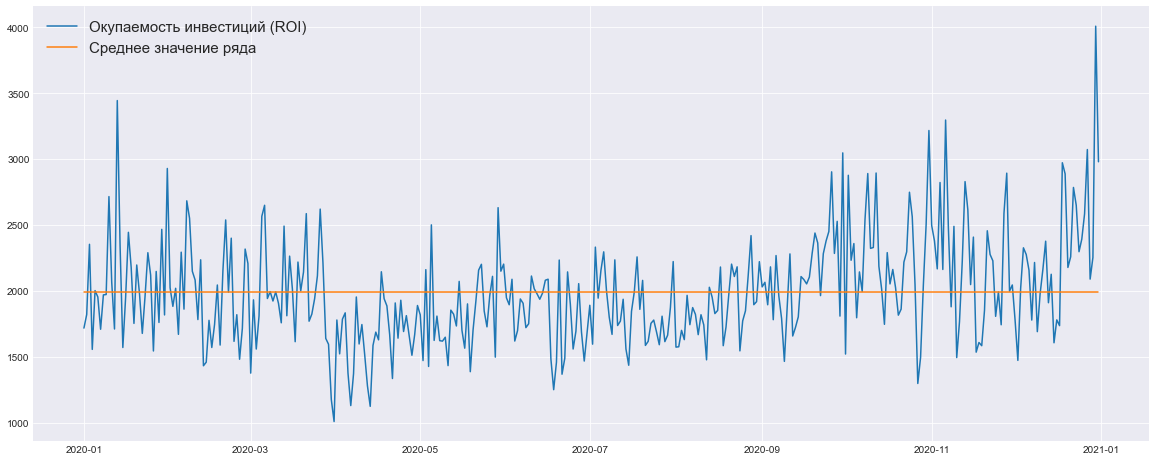

In [30]:
# Среднее значение
ROI['Mean'] = ROI['ROI'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(ROI['ROI'], label = 'Окупаемость инвестиций (ROI)')
plt.plot(ROI['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size':15})

# Среднее значение
print("Среднее значение:", round(ROI['ROI'].mean(),2))

In [31]:
print('Медиана ROI:', round(data_CR_CPA_ROI['ROI'].median(),2))
print("Среднее значение ROI:", round(data_CR_CPA_ROI['ROI'].mean(),2))
print('Мода ROI:', round(data_CR_CPA_ROI['ROI'].mode(),2))

Медиана ROI: 1941.38
Среднее значение ROI: 1987.8
Мода ROI: 0      1007.84
1      1123.22
2      1129.04
3      1174.49
4      1249.67
        ...   
361    3072.87
362    3217.25
363    3296.80
364    3444.68
365    4009.33
Length: 366, dtype: float64


# Вывод
   1.  В среднем окупаемость инвестиций составляет 1941.38 (Среднее значение ROI)
   2.  Значение, находящиеся в середине выборки составляет 1987.8 (Медиана ROI)
   3.  В нашей выборке имеется 367 самых встречающихся значений (Мода ROI):
   4.  Среднее значение ROI(1941.38) примерно равно медиане ROI(1987.8), соответственно гипотеза о нормальности данных не отвергается 

max: 4009
75%: 2206
50%: 1941
25%: 1712
min: 1008


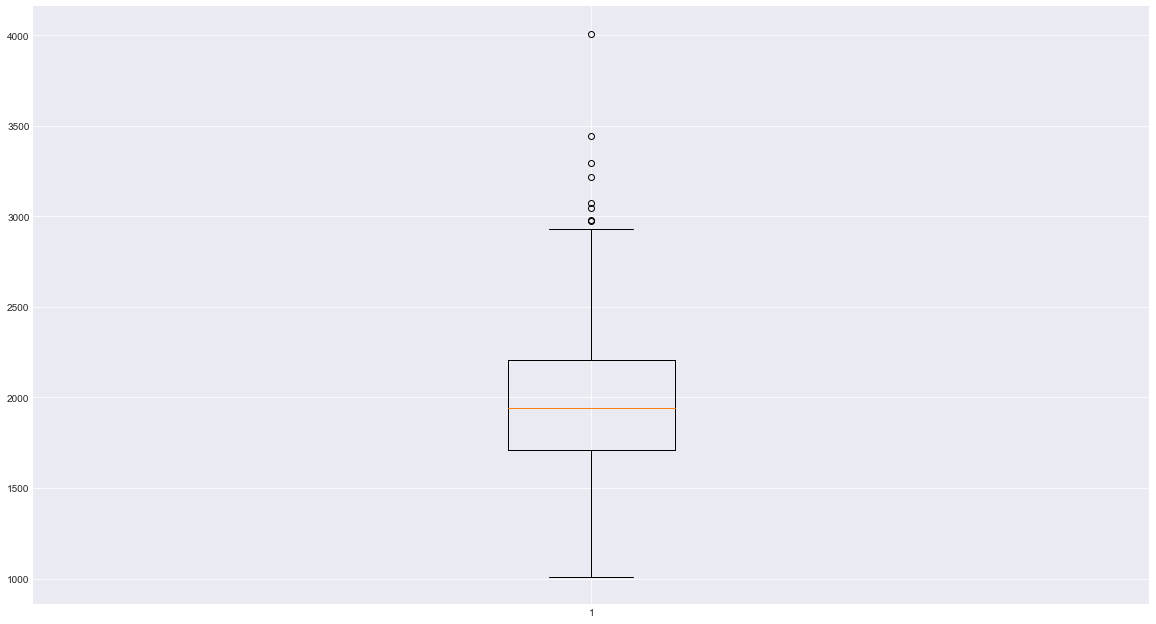

In [32]:
print('max:', round(data_CR_CPA_ROI['ROI'].quantile(q=1.0)))
print('75%:', round(data_CR_CPA_ROI['ROI'].quantile(q=0.75)))
print('50%:', round(data_CR_CPA_ROI['ROI'].quantile(q=0.5)))
print('25%:', round(data_CR_CPA_ROI['ROI'].quantile(q=0.25)))
print('min:', round(data_CR_CPA_ROI['ROI'].quantile(q=0.0)))


np.random.seed(10)
data = np.random.normal(50, 10, 100)
 
fig = plt.figure(figsize =(20, 11))
 

plt.boxplot(data_CR_CPA_ROI['ROI'])
 

plt.show()

# Вывод:
1. До 25% данных имеют значение 1712, что выше минимального показателя на 712. При увеличении вероятности с 25% по 50% и с 50% по 75% происходит умеренный рост значений, в первом случае он составляет 229, а во втором 265. Большая разница имеется между последними квантилями и она равна 1803.
2. На диаграмме видно, что 50% данных имеют примерно одинаковые значения и большого разброса не наблюдается, однако есть выбросы, что свидетельствует о наличии нетипичных наблюдений.
3. Квантили и диаграмма свидетельствуют о высокой рентабельности инвестиций, внесённых в течении года.

# CPA - Меры центральной тенденции: среднее значение, медиана, мода

In [34]:
CPA=data_CR_CPA_ROI
CPA.head(10)

,date,cost,transactions,visits,CPA,CR,ROI
0,2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
1,2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2,2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
3,2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
4,2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
5,2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
6,2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
7,2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
8,2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92
9,2020-01-10,171419.51,3607,22455,47.52,16.06,2715.57


In [35]:
CPA.index = CPA['date']
CPA = CPA.drop(['date'], axis = 1)
CPA.head(10)

,cost,transactions,visits,CPA,CR,ROI
date,,,,,,
2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92


Среднее значение: 60.47


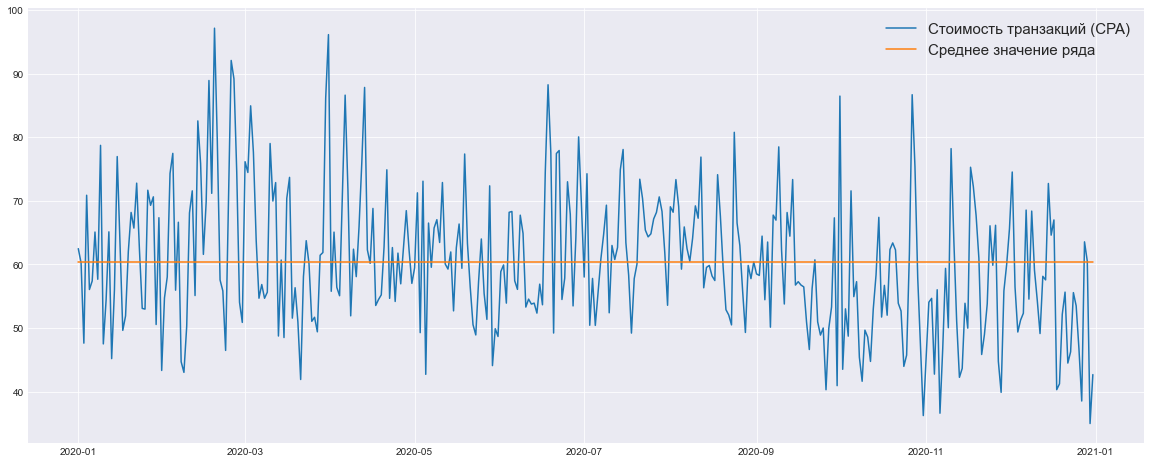

In [36]:
# Среднее значение
CPA['Mean'] = CPA['CPA'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(CPA['CPA'], label = 'Стоимость транзакций (CPA)')
plt.plot(CPA['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size':15})

# Среднее значение
print("Среднее значение:", round(CPA['CPA'].mean(),2))

In [37]:
print('Медиана CPA:', round(data_CR_CPA_ROI['CPA'].median(),2))
print("Среднее значение CPA:", round(data_CR_CPA_ROI['CPA'].mean(),2))
print('Мода CPA:', round(data_CR_CPA_ROI['CPA'].mode(),2))

Медиана CPA: 59.39
Среднее значение CPA: 60.47
Мода CPA: 0     52.99
1     53.91
2     53.93
3     54.07
4     54.40
5     54.56
6     54.68
7     56.77
8     57.30
9     57.78
10    59.85
11    60.08
12    62.49
13    68.33
14    69.09
15    70.88
16    71.57
dtype: float64


# Вывод
   1.  В среднем стоимость транзакции составляет 59,39 (Среднее значение CPA)
   2.  Значение, находящиеся в середине выборки составляет 60,47 (Медиана CPA)
   3.  В нашей выборке имеется 18 самых встречающихся значений (Мода CPA):
   4.  Среднее значение CPA(59,39) примерно равно медиане CPA(60,47), соответственно гипотеза о нормальности данных не отвергается 

max: 97
75%: 68
50%: 59
25%: 53
min: 35


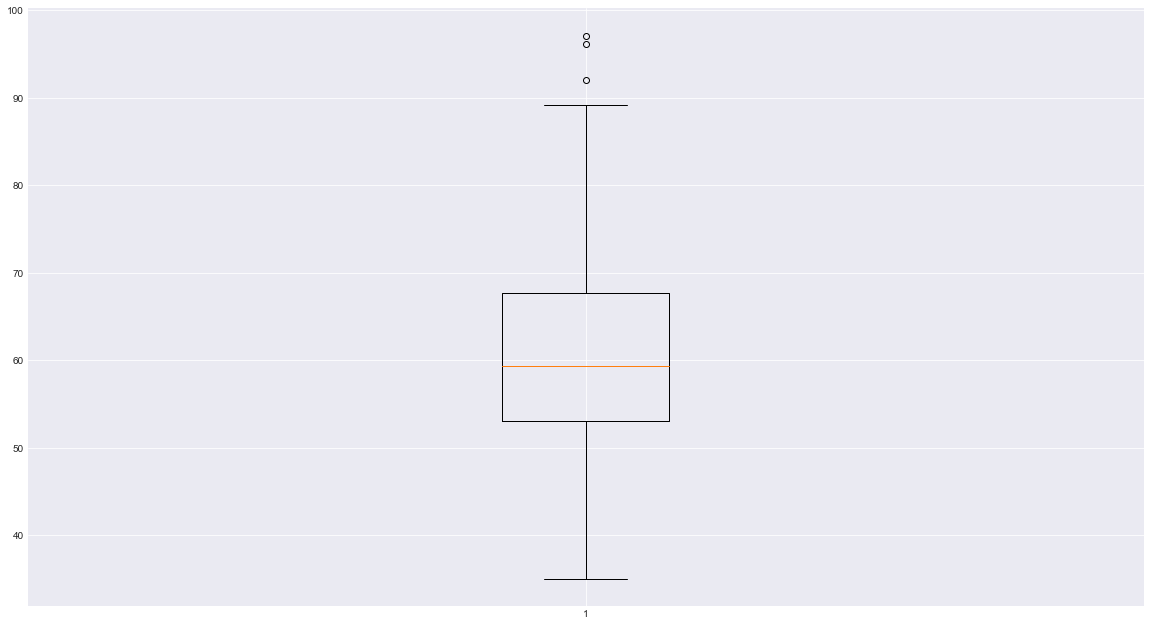

In [38]:
print('max:', round(data_CR_CPA_ROI['CPA'].quantile(q=1.0)))
print('75%:', round(data_CR_CPA_ROI['CPA'].quantile(q=0.75)))
print('50%:', round(data_CR_CPA_ROI['CPA'].quantile(q=0.5)))
print('25%:', round(data_CR_CPA_ROI['CPA'].quantile(q=0.25)))
print('min:', round(data_CR_CPA_ROI['CPA'].quantile(q=0.0)))


np.random.seed(10)
data = np.random.normal(50, 10, 100)
 
fig = plt.figure(figsize =(20, 11))
 

plt.boxplot(data_CR_CPA_ROI['CPA'])
 

plt.show()

# Вывод
1. Самый большой показатель наблюдается в диапазоне от 75% до максимального квантиля, значения увеличиваются на 30%.
2. На диаграмме видно, что 50% данных имеют примерно одинаковые значения и большого разброса не наблюдается, однако есть выбросы, что свидетельствует о наличии нетипичных наблюдений.
3. Квантили и диаграмма свидетельствуют о стабильно высокой стоимости транзакций.

# CR - Меры центральной тенденции: среднее значение, медиана, мода

In [40]:
CR=data_CR_CPA_ROI
CR.head(10)

,date,cost,transactions,visits,CPA,CR,ROI
0,2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
1,2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2,2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
3,2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
4,2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
5,2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
6,2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
7,2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
8,2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92
9,2020-01-10,171419.51,3607,22455,47.52,16.06,2715.57


In [41]:
CR.index = CR['date']
CR = CR.drop(['date'], axis = 1)
CR.head(10)

,cost,transactions,visits,CPA,CR,ROI
date,,,,,,
2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92


Среднее значение: 15.35


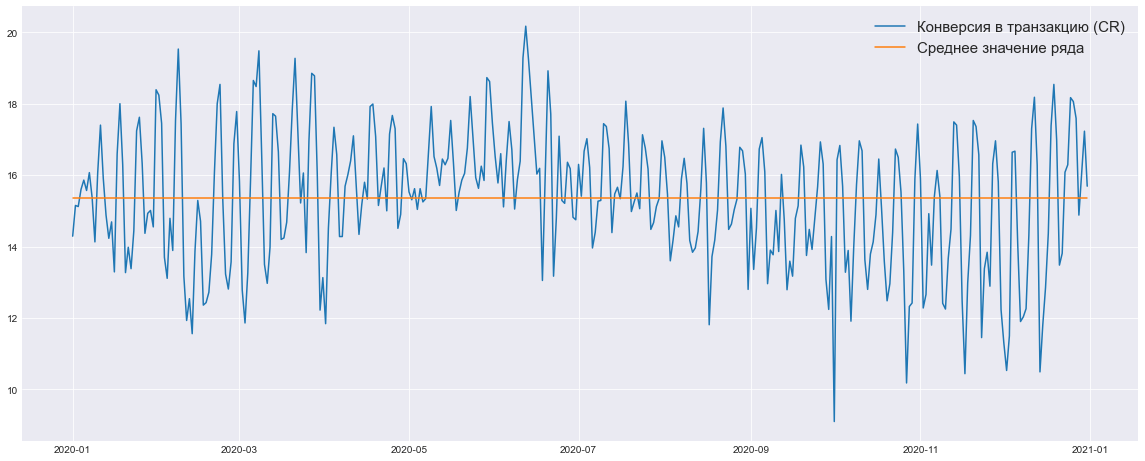

In [42]:
# Среднее значение
CR['Mean'] = CR['CR'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(CR['CR'], label = 'Конверсия в транзакцию (CR)')
plt.plot(CR['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size':15})

# Среднее значение
print("Среднее значение:", round(CR['CR'].mean(),2))

In [43]:
print('Медиана CR:', round(data_CR_CPA_ROI['CR'].median(),2))
print("Среднее значение CR:", round(data_CR_CPA_ROI['CR'].mean(),2))
print('Мода CR:', round(data_CR_CPA_ROI['CR'].mode(),2))

Медиана CR: 15.52
Среднее значение CR: 15.35
Мода CR: 0    15.69
1    16.96
dtype: float64


# Вывод
   1.  В среднем конверсия составляет 15.52% (Среднее значение CR)
   2.  Значение, находящиеся в середине выборки составляет 15.35% (Медиана CR)
   3.  В нашей выборке имеется 3 самых встречающихся значения (Мода CR)
   4.  Среднее значение (15.52), медиана(15.35) и мода(15.69, 16,96) CR  имеют примерно одинаковые значения, соответственно гипотеза о нормальности данных не отвергается. 

max: 20
75%: 17
50%: 16
25%: 14
min: 9


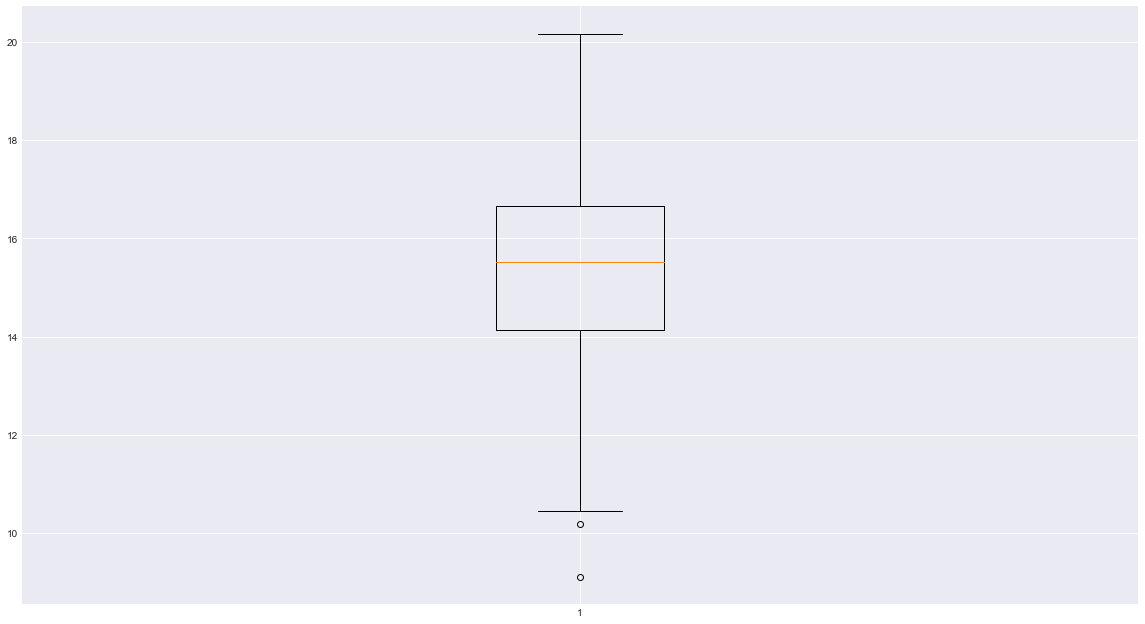

In [44]:
print('max:', round(data_CR_CPA_ROI['CR'].quantile(q=1.0)))
print('75%:', round(data_CR_CPA_ROI['CR'].quantile(q=0.75)))
print('50%:', round(data_CR_CPA_ROI['CR'].quantile(q=0.5)))
print('25%:', round(data_CR_CPA_ROI['CR'].quantile(q=0.25)))
print('min:', round(data_CR_CPA_ROI['CR'].quantile(q=0.0)))


np.random.seed(10)
data = np.random.normal(50, 10, 100)
 
fig = plt.figure(figsize =(20, 11))
 

plt.boxplot(data_CR_CPA_ROI['CR'])
 

plt.show()

# Вывод
1. Разница между каждым квантилем примерно одинаковая, значения распределены равномерно.
2. На диаграмме видно, что 50% данных имеют примерно одинаковые значения и большого разброса не наблюдается, однако есть выбросы, что свидетельствует о наличии нетипичных наблюдений.
3. Квантили и диаграмма свидетельствуют о стабильных показателях конверсии в транзакцию в течении года.

# Сравнение результатов поазателей ROI, CPA и CR

In [52]:
print("Среднее значение ROI:", round(data_CR_CPA_ROI['ROI'].mean(),2))
print("Дисперсия ROI:", round(data_CR_CPA_ROI['ROI'].var(),2))
print("Стандартное отклонение ROI:", round(data_CR_CPA_ROI['ROI'].std(),2))

Среднее значение ROI: 1987.8
Дисперсия ROI: 162494.32
Стандартное отклонение ROI: 403.11


In [53]:
print("Среднее значение CPA:", round(data_CR_CPA_ROI['CPA'].mean(),2))
print("Дисперсия CPA:", round(data_CR_CPA_ROI['CPA'].var(),2))
print("Стандартное отклонение CPA:", round(data_CR_CPA_ROI['CPA'].std(),2))

Среднее значение CPA: 60.47
Дисперсия CPA: 119.28
Стандартное отклонение CPA: 10.92


In [54]:
print("Среднее значение CR:", round(data_CR_CPA_ROI['CR'].mean(),2))
print("Дисперсия CR:", round(data_CR_CPA_ROI['CR'].var(),2))
print("Стандартное отклонение CR:", round(data_CR_CPA_ROI['CR'].std(),2))

Среднее значение CR: 15.35
Дисперсия CR: 3.48
Стандартное отклонение CR: 1.87


# Выводы
   1. Самая большая  дисперсия наблюдается у ROI, а самая низкая у CR.
   2. Самое высокое стандартное отклонение показывает ROI, а самое низкое CR.
   3. Из результатов расчётов дисперсии и стандартного отклонения следует вывод о наличии большого у ROI, умеренного у CPA и маленького у CR разброса данных. Данная ситуация говорит о том, что CPA и CR были в течении года был примерно одинаковыми, а значения ROI сильно колебались.

In [55]:
data_CR_CPA_ROI.index = data_CR_CPA_ROI['date']
data_CR_CPA_ROI = data_CR_CPA_ROI.drop(['date'], axis = 1)
data_CR_CPA_ROI.head(10)

,cost,transactions,visits,CPA,CR,ROI
date,,,,,,
2020-01-01,194157.68,3107,21736,62.49,14.29,1717.17
2020-01-02,253517.21,4208,27774,60.25,15.15,1820.00
2020-01-03,202933.46,4260,28168,47.64,15.12,2353.32
2020-01-04,322447.14,4549,29164,70.88,15.60,1555.56
2020-01-05,252197.35,4498,28360,56.07,15.86,2001.92
2020-01-06,244448.73,4258,27349,57.41,15.57,1953.48
2020-01-07,285459.79,4385,27288,65.10,16.07,1708.43
2020-01-08,209363.66,3630,23622,57.68,15.37,1969.46
2020-01-09,232071.32,2948,20860,78.72,14.13,1971.92


Среднее значение: 1987.8
Среднее значение: 60.47
Среднее значение: 15.35


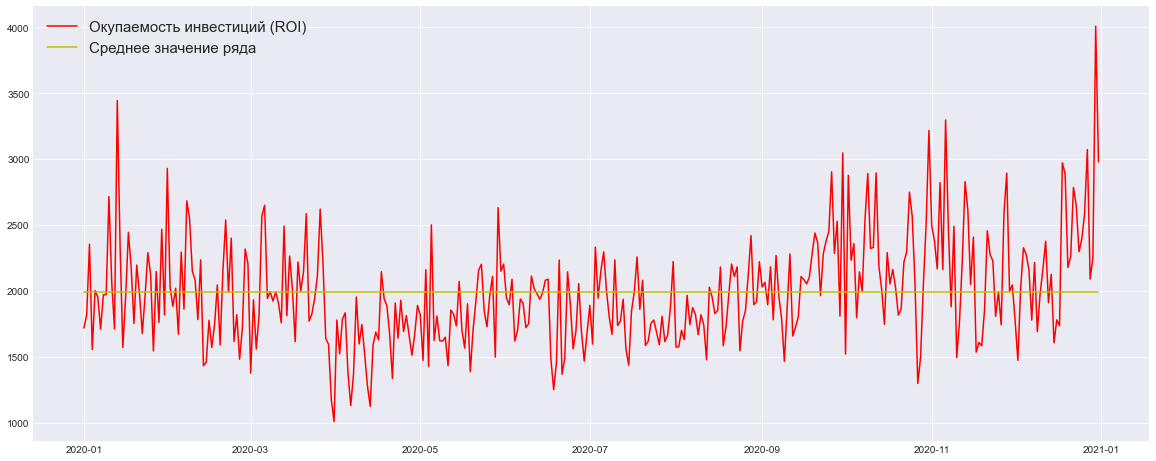

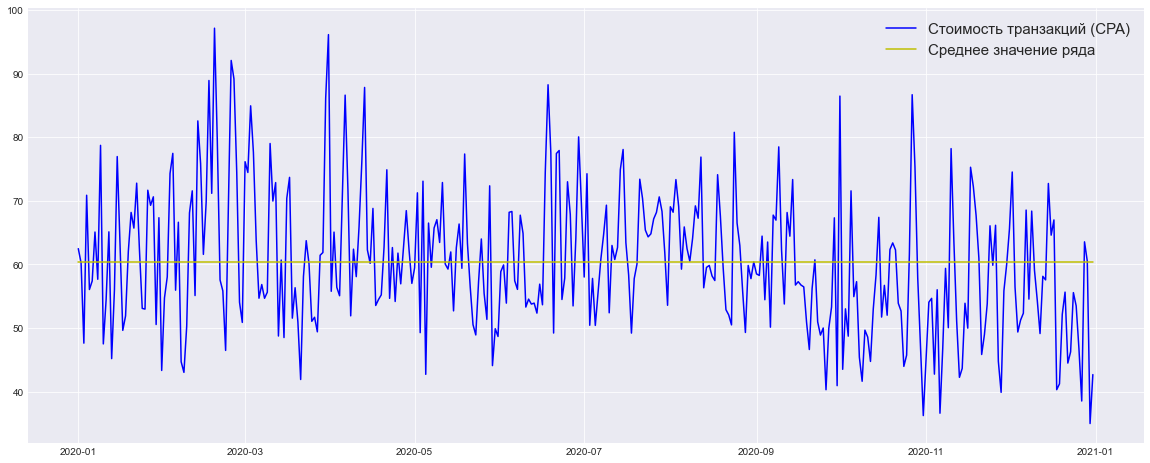

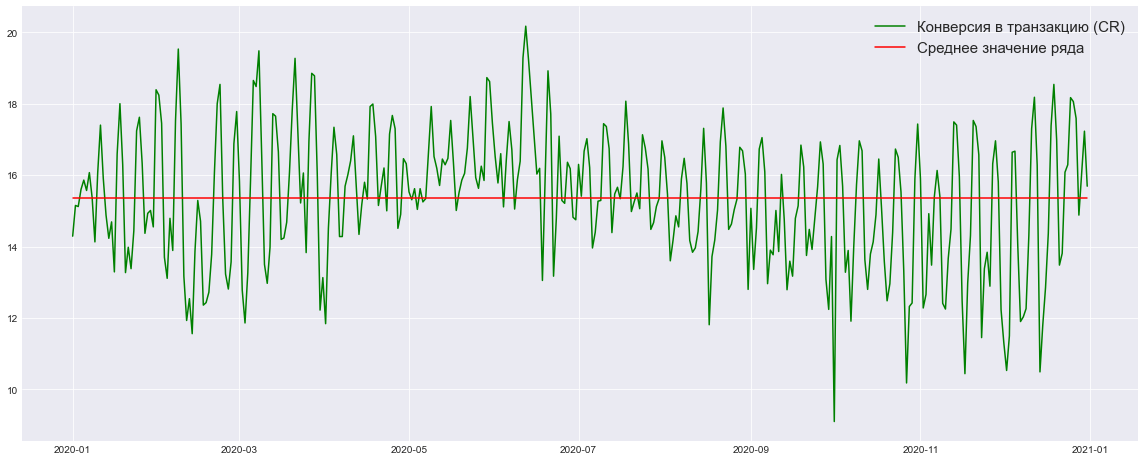

In [56]:
# Среднее значение
ROI['Mean'] = ROI['ROI'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(ROI['ROI'], color = 'r', label = 'Окупаемость инвестиций (ROI)')
plt.plot(ROI['Mean'], color = 'y', label = 'Среднее значение ряда')
plt.legend(prop={'size':15})


# Среднее значение
print("Среднее значение:", round(ROI['ROI'].mean(),2))

# Среднее значение
CPA['Mean'] = CPA['CPA'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(CPA['CPA'], color = 'b', label = 'Стоимость транзакций (CPA)')
plt.plot(CPA['Mean'], color = 'y', label = 'Среднее значение ряда')
plt.legend(prop={'size':15})


# Среднее значение
print("Среднее значение:", round(CPA['CPA'].mean(),2))

# Среднее значение
CR['Mean'] = CR['CR'].mean()

# График
plt.figure(figsize=(20, 8))
plt.plot(CR['CR'], color = 'g', label = 'Конверсия в транзакцию (CR)')
plt.plot(CR['Mean'], color = 'r', label = 'Среднее значение ряда')
plt.legend(prop={'size':15})


# Среднее значение
print("Среднее значение:", round(CR['CR'].mean(),2))

# Вывод:
  1. На графике видна равномерная динамика значений у параметра CR. Самые высокие показатели конверсии были с января по апрель и в июне, а затем происходил незначительный спад. К концу года CR стал расти. 
  2. Амплитуда колебаний  по метрике CPA имеют примерно такую же специфику как и у CR, однако разброс между минимальными и максимальными значениями более существенный чем у конверсии. 
  3. Динамика распределения данных у ROI неравномерна. На графике видны сильные колебания. Максимальные значения наблюдались с января по апрель, а затем происходил резкий спад, а с сентября месяца, за исключением первой половины декабря, наблюдалось стабильное увеличение показателей.
  
  Гипотеза по CR и CPA: 
  Максимальные значения в первые три месяца и в конце года связаны с праздничными днями, а в июне со снижением ограничений, введённых в связи с пандемией коронавируса. Клиенты, позитивно воспринимая ослабление мер по режиму самоизоляции, стали чаще пользоваться услугами доставки товаров в июне месяце(например в офисе могли отметить снятие локдауна с организацией неформальных встреч и из-за этого стало увеличиваться количество заказов). Снижение показателей после июня объяснется возвращением людей в прежний темп жизни, поэтому динамика данного параметра в целом умеренная.
  
  Гипотеза по ROI:
  Неравномерное распределение значений по данной метрике, также связаны с праздничными днями и с введением режима самоизоляции. Отличие специфики динамики распределения данных ROI от CPA и CR, объясняется тем, что первый параметр учитывает поступление количества денежных средств, а вторые две общую финансовую активность. В данной связи можно констатировать, что в целом количество транзакций не уменьшилось, а сократилось количество поступаемых средств(снижение среднего чека, уменьшение количества покупаемых товаров)    

# 3 этап курсовой. Кластерный анализ по взаимосвязи добавления товаров в корзину и совершению транзакций пользователями из разных городов.

In [57]:
City_Transactions_addToCart = """SELECT city,
       transactions,
       addToCart,
 FROM `astute-asset-303615.Project_3.ga_data`
 group by 1,2,3
 order by 1"""

data_City_Transactions_addToCart= pandas_gbq.read_gbq(City_Transactions_addToCart, project_id='astute-asset-303615')
data_City_Transactions_addToCart.head(10)

Downloading: 100%|█████████████████████████████████████████████████████████████| 4771/4771 [00:00<00:00, 9381.64rows/s]


,city,transactions,addToCart
0,Ангарск,1,6
1,Ангарск,0,0
2,Ангарск,1,4
3,Ангарск,1,0
4,Ангарск,0,4
5,Ангарск,1,8
6,Ангарск,1,12
7,Ангарск,0,6
8,Ангарск,1,2
9,Ангарск,1,10


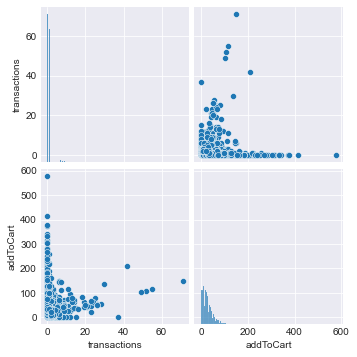

In [58]:
sns.pairplot(data_City_Transactions_addToCart)
plt.show()

In [59]:
City=data_City_Transactions_addToCart[['city']]
City

,city
0,Ангарск
1,Ангарск
2,Ангарск
3,Ангарск
4,Ангарск
...,...
4766,Электросталь
4767,Электросталь
4768,Электросталь
4769,Электросталь


In [60]:
le = LabelEncoder()

In [61]:
city=le.fit_transform(City)
city

C:\Users\aleks\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([ 0,  0,  0, ..., 59, 59, 59])

In [62]:
city=pd.DataFrame(city)
city.head(10)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [63]:
Transactions_addToCart = data_City_Transactions_addToCart[['transactions', 'addToCart']]
Transactions_addToCart.head(10)

,transactions,addToCart
0,1,6
1,0,0
2,1,4
3,1,0
4,0,4
5,1,8
6,1,12
7,0,6
8,1,2
9,1,10


In [64]:
Transactions_data = data_City_Transactions_addToCart[['transactions']]
Transactions_data.head(10)

,transactions
0,1
1,0
2,1
3,1
4,0
5,1
6,1
7,0
8,1
9,1


In [65]:
addToCart_data = data_City_Transactions_addToCart[['addToCart']]
addToCart_data.head(10)

,addToCart
0,6
1,0
2,4
3,0
4,4
5,8
6,12
7,6
8,2
9,10


In [66]:
City_Transactions_addToCart_data = city
City_Transactions_addToCart_data.head(10)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [67]:
City_Transactions_addToCart_data['transactions'] = Transactions_data
City_Transactions_addToCart_data.head(10)

,0,transactions
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0
5,0,1
6,0,1
7,0,0
8,0,1
9,0,1


In [68]:
City_Transactions_addToCart_data['addToCart'] = addToCart_data
City_Transactions_addToCart_data.head(10)

,0,transactions,addToCart
0,0,1,6
1,0,0,0
2,0,1,4
3,0,1,0
4,0,0,4
5,0,1,8
6,0,1,12
7,0,0,6
8,0,1,2
9,0,1,10


In [69]:
City_Transactions_addToCart_data=City_Transactions_addToCart_data.rename(columns={0: "city"})
City_Transactions_addToCart_data.head(10)

,city,transactions,addToCart
0,0,1,6
1,0,0,0
2,0,1,4
3,0,1,0
4,0,0,4
5,0,1,8
6,0,1,12
7,0,0,6
8,0,1,2
9,0,1,10


In [70]:
col=['city', 'transactions', 'addToCart']

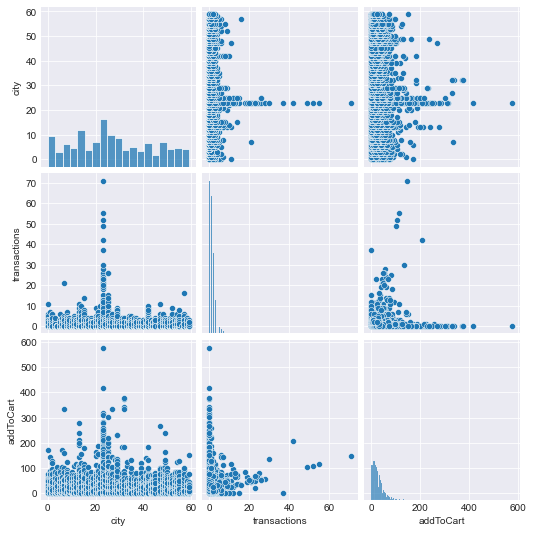

In [71]:
sns.pairplot(City_Transactions_addToCart_data)
plt.show()

In [72]:
from sklearn import preprocessing

# Приведение данных к нормальным значениям
dataNorm= preprocessing.MinMaxScaler().fit_transform(City_Transactions_addToCart_data[col].values)

In [73]:
dataNorm[:2]

array([[0.        , 0.01408451, 0.01038062],
       [0.        , 0.        , 0.        ]])

In [74]:
# вычисление евклидового расстояния

data_dist = pdist(dataNorm, 'euclidean')

In [75]:
# объединение элементов в кластера и сохранение в переменной

data_linkage = linkage(data_dist, method='average')

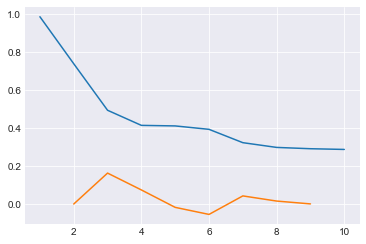

Рекомендованное количество кластеров: 3


In [76]:
# определение рекомендованного количества кластеров методом локтя

last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last)+1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1] 
plt.plot(idxs[:-2] +1, acceleration_rev)
plt.show()
k=acceleration_rev.argmax()+2
print("Рекомендованное количество кластеров:", k)

In [77]:
# Функция построения дендограмм
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    
    ddata = dendrogram(*args, **kwargs)
    
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                            textcoords='offset points',
                            va='top', ha='center')
                if max_d:
                    plt.axhline(y=max_d, c='k')
            return ddata

In [78]:
# определение количества кластеров

nClust=6

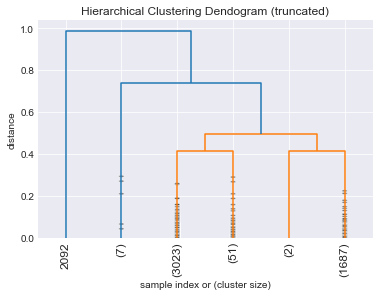

In [79]:
# выведение дендограммы

fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nClust,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

In [80]:
# иерархическая кластеризация

clusters=fcluster(data_linkage, nClust, criterion='maxclust')
clusters

array([2, 2, 2, ..., 5, 5, 5], dtype=int32)

In [81]:
col

['city', 'transactions', 'addToCart']

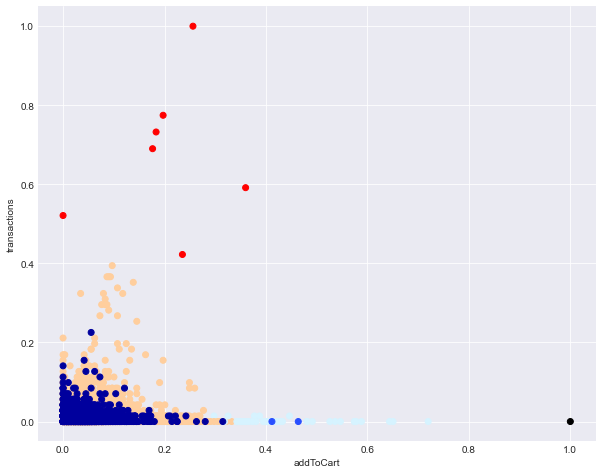

In [82]:
# Визуализация кластерного анализа

x=2
y=1
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=clusters, cmap='flag')
plt.xlabel(col[x])
plt.ylabel(col[y]);
plt.show()

In [83]:
City_Transactions_addToCart_data['clusters']=clusters
res=City_Transactions_addToCart_data.groupby('clusters').mean()
res['Количество']=City_Transactions_addToCart_data.groupby('clusters').size().values

# Выведение количества оъектов, относяхщихся к определённому кластеру

res

,city,Количество
clusters,,
1,23.000000,7
2,17.305657,3023
3,20.372549,51
4,48.000000,2
5,46.047421,1687
6,23.000000,1


In [84]:
clusters

array([2, 2, 2, ..., 5, 5, 5], dtype=int32)

In [85]:
i=pd.DataFrame(clusters)
i

,0
0,2
1,2
2,2
3,2
4,2
...,...
4766,5
4767,5
4768,5
4769,5


In [86]:
City_Transactions_addToCart_data.head(10)

,city,transactions,addToCart,clusters
0,0,1,6,2
1,0,0,0,2
2,0,1,4,2
3,0,1,0,2
4,0,0,4,2
5,0,1,8,2
6,0,1,12,2
7,0,0,6,2
8,0,1,2,2
9,0,1,10,2


In [87]:
City_Transactions_addToCart_data[City_Transactions_addToCart_data['clusters'] ==1]

,city,transactions,addToCart,clusters
1921,23,55,114,1
1958,23,71,148,1
1993,23,52,106,1
2059,23,37,0,1
2175,23,42,208,1
2185,23,30,136,1
2196,23,49,102,1


In [88]:
City

,city
0,Ангарск
1,Ангарск
2,Ангарск
3,Ангарск
4,Ангарск
...,...
4766,Электросталь
4767,Электросталь
4768,Электросталь
4769,Электросталь


In [89]:
City_Transactions_addToCart_data_with_Clusters=City_Transactions_addToCart_data

In [90]:
# Объединение данных с названиями городов и кластерами в один датафрейм

City_Transactions_addToCart_data_with_Clusters['City']=City
City_Transactions_addToCart_data_with_Clusters.head(10)

,city,transactions,addToCart,clusters,City
0,0,1,6,2,Ангарск
1,0,0,0,2,Ангарск
2,0,1,4,2,Ангарск
3,0,1,0,2,Ангарск
4,0,0,4,2,Ангарск
5,0,1,8,2,Ангарск
6,0,1,12,2,Ангарск
7,0,0,6,2,Ангарск
8,0,1,2,2,Ангарск
9,0,1,10,2,Ангарск


In [91]:
# 1 кластер

Cluster_One=City_Transactions_addToCart_data_with_Clusters[City_Transactions_addToCart_data_with_Clusters['clusters'] ==1]
Cluster_One

,city,transactions,addToCart,clusters,City
1921,23,55,114,1,Москва
1958,23,71,148,1,Москва
1993,23,52,106,1,Москва
2059,23,37,0,1,Москва
2175,23,42,208,1,Москва
2185,23,30,136,1,Москва
2196,23,49,102,1,Москва


In [98]:
print("процент вероятности совершения транзакций при добавлении товара в корзину:", round(round(Cluster_One.transactions.mean())/round(Cluster_One.addToCart.mean())*100))

процент вероятности совершения транзакций при добавлении товара в корзину: 41


In [99]:
# 2 кластер

Cluster_Two= City_Transactions_addToCart_data_with_Clusters[City_Transactions_addToCart_data_with_Clusters['clusters'] ==2]
Cluster_Two.head(10)

,city,transactions,addToCart,clusters,City
0,0,1,6,2,Ангарск
1,0,0,0,2,Ангарск
2,0,1,4,2,Ангарск
3,0,1,0,2,Ангарск
4,0,0,4,2,Ангарск
5,0,1,8,2,Ангарск
6,0,1,12,2,Ангарск
7,0,0,6,2,Ангарск
8,0,1,2,2,Ангарск
9,0,1,10,2,Ангарск


In [100]:
Cluster_Two.City.value_counts()

Москва             349
Не определено      201
Новосибирск        156
Иркутск            146
Кемерово           126
Казань             117
Екатеринбург       117
Красноярск         113
Краснодар          105
Барнаул             97
Ангарск             86
Зеленоград          83
Новокузнецк         75
Мытищи              75
Балашиха            74
Королев             73
Владимир            72
Люберцы             70
Норильск            69
Белгород            68
Нижневартовск       67
Домодедово          65
Долгопрудный        65
Котельники          64
Иваново             63
Железнодорожный     63
Обнинск             62
Жуковский           56
Новороссийск        51
Красногорск         48
Климовск            43
Ногинск             34
Одинцово            27
Бишкек              20
Октябрьский         18
Омск                 4
Подольск             1
Name: City, dtype: int64

In [101]:
print("процент вероятности совершения транзакций при добавлении товара в корзину:", round(round(Cluster_Two.transactions.mean())/round(Cluster_Two.addToCart.mean())*100))

процент вероятности совершения транзакций при добавлении товара в корзину: 6


In [102]:
# 3 кластер

Cluster_Tree=City_Transactions_addToCart_data_with_Clusters[City_Transactions_addToCart_data_with_Clusters['clusters'] ==3]
Cluster_Tree.head(10)

,city,transactions,addToCart,clusters,City
77,0,0,170,3,Ангарск
145,1,0,144,3,Балашиха
237,2,0,128,3,Барнаул
242,2,1,118,3,Барнаул
485,6,1,172,3,Долгопрудный
528,7,0,334,3,Домодедово
542,7,0,158,3,Домодедово
1016,13,0,144,3,Иркутск
1030,13,0,212,3,Иркутск
1042,13,0,278,3,Иркутск


In [103]:
Cluster_Tree.City.value_counts()

Москва           22
Иркутск           6
Не определено     5
Обнинск           5
Барнаул           2
Домодедово        2
Новосибирск       2
Ангарск           1
Балашиха          1
Долгопрудный      1
Казань            1
Кемерово          1
Новокузнецк       1
Норильск          1
Name: City, dtype: int64

In [104]:
print("процент вероятности совершения транзакций при добавлении товара в корзину:", round(round(Cluster_Tree.transactions.mean())/round(Cluster_Tree.addToCart.mean())*100))

процент вероятности совершения транзакций при добавлении товара в корзину: 0


In [105]:
# 4 кластер

Cluster_Four=City_Transactions_addToCart_data_with_Clusters[City_Transactions_addToCart_data_with_Clusters['clusters'] ==4]
Cluster_Four

,city,transactions,addToCart,clusters,City
4014,47,0,268,4,Тверь
4161,49,0,238,4,Томск


In [106]:
print("процент вероятности совершения транзакций при добавлении товара в корзину:", round(round(Cluster_Four.transactions.mean())/round(Cluster_Four.addToCart.mean())*100))

процент вероятности совершения транзакций при добавлении товара в корзину: 0


In [107]:
# 5 кластер

Cluster_Five=City_Transactions_addToCart_data_with_Clusters[City_Transactions_addToCart_data_with_Clusters['clusters'] ==5]
Cluster_Five.head(10)

,city,transactions,addToCart,clusters,City
3037,33,1,36,5,Одинцово
3042,33,1,40,5,Одинцово
3048,33,1,24,5,Одинцово
3049,33,0,18,5,Одинцово
3051,33,1,20,5,Одинцово
3054,33,0,20,5,Одинцово
3055,33,1,28,5,Одинцово
3056,33,1,18,5,Одинцово
3057,33,2,34,5,Одинцово
3058,33,1,42,5,Одинцово


In [108]:
Cluster_Five.City.value_counts()

Самара          115
Тверь           106
Томск            92
Щелково          87
Рязань           82
Омск             81
Тюмень           77
Тольятти         74
Уфа              74
Пенза            71
Сходня           70
Химки            67
Ульяновск        65
Подольск         59
Сургут           58
Реутов           57
Фрязино          57
Сочи             57
Раменское        55
Пушкино          55
Электросталь     54
Троицк           53
Щербинка         52
Октябрьский      44
Одинцово         21
Челябинск         3
Тамбов            1
Name: City, dtype: int64

In [109]:
print("процент вероятности совершения транзакций при добавлении товара в корзину:", round(round(Cluster_Five.transactions.mean())/round(Cluster_Five.addToCart.mean())*100))

процент вероятности совершения транзакций при добавлении товара в корзину: 4


In [110]:
# 6 кластер

Cluster_Six=City_Transactions_addToCart_data_with_Clusters[City_Transactions_addToCart_data_with_Clusters['clusters'] ==6]
Cluster_Six

,city,transactions,addToCart,clusters,City
2092,23,0,578,6,Москва


In [111]:
print("процент вероятности совершения транзакций при добавлении товара в корзину:", round(round(Cluster_Six.transactions.mean())/round(Cluster_Six.addToCart.mean())*100))

процент вероятности совершения транзакций при добавлении товара в корзину: 0


# Вывод
   1. Большинство объектов относятся к 2 и 5 кластеру, где верятность совершения транзакций при добавлении товаров в корзину в первом случае составляет 5%, во втором 4%.
   2. Объекты 1 и 6 кластера относятся к нетипичным наблюдениям, в первом случае вероятность совершения транзакции при добавлении товаров в корзину составляет составляет 41%, во втором имеется самый большой разрыв между показтелями addToCart(578) и transactions(0), при этом обе ситуации связаны с пользователями из города Москвы. Гипотезы: 
   - большая вероятность совершения транзакциий при добавлении товаров в корзину пользователями из Москвы обусловлена высокими доходами жителей города, более развитым сервисом доставки товаров и частыми заказами еды в офис;
   - наличие большого количества добавления товаров в корзину при отсутствии транзакций связан с введением режима самоизоляции и переводом работников на удалённый режим работы(в данном случае не было необходимости заказавать заранее запланированный товар, так как пользователи внезапно вынужденны менять образ жизни).
   3. Большинство действий(добавление товаров в корзину, осуществление транзакций) совершалось пользователями из Москвы